# Segmenting bank customers

## Dataset related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed. 

Nuno António - Rev. 1.00 - January, 2020

### Dataset description

#### bank client data:
- **age**: numeric - age of the customer
- **job**: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- **marital**: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- **education**: (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- **default**: has credit in default? (categorical: 'no','yes','unknown')
- **housing**: has housing loan? (categorical: 'no','yes','unknown')
- **loan**: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
- **contact**: contact communication type (categorical: 'cellular','telephone') 
- **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
- **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- **previous**: number of contacts performed before this campaign and for this client (numeric)
- **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
- **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
- **cons.price.idx**: consumer price index - monthly indicator (numeric) 
- **cons.conf.idx**: consumer confidence index - monthly indicator (numeric) 
- **euribor3m**: euribor 3 month rate - daily indicator (numeric)
- **nr.employed**: number of employees - quarterly indicator (numeric)

#### subscrition info
- **y**: has the client subscribed a term deposit? (binary: 'yes','no')



More information on the dataset available at https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

<font color='blue'>Q1: Segmentation should use demographic, behavioral, geographic, or life cycle characteristics. Given this, should we use all the variables in the dataset?</font><br>
<font color='blue'>Q2: Segmentation can help develop customer retention strategies, promote superior customer experience, advertisement targeting, among other use cases. With this dataset, what could this bank to with a good customer segmentation?</font>

### Initial setup and modules/packages loading

In [21]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import collections
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Data understanding

In [22]:
# Load data 
ds = pd.read_csv('bank-additional-full.csv', sep=";")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [23]:
# Display top 15 rows
ds.head(15)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [24]:
# Summary statistics for all variables
summary=ds.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188,NaN,NaN,NaN,40.0241,10.4212,17,32,38,47,98
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color='blue'>Q2: Do numeric variables statistics show any strange patterns?</font>

In [25]:
# Check counts of categorical variables
cols = ['default', 'housing', 'loan', 'poutcome' , 'y']
ds[cols].apply(pd.Series.value_counts)

,default,housing,loan,poutcome,y
failure,NaN,NaN,NaN,4252.0,NaN
no,32588.0,18622.0,33950.0,NaN,36548.0
nonexistent,NaN,NaN,NaN,35563.0,NaN
success,NaN,NaN,NaN,1373.0,NaN
unknown,8597.0,990.0,990.0,NaN,NaN
yes,3.0,21576.0,6248.0,NaN,4640.0


<font color='blue'>Q3: Is the dataset balanced?</font>

In [26]:
# Check missing values
print(ds.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [27]:
# Exploration of categorical variables: cross table of job and education
table1 = pd.crosstab(index=ds['job'], columns=ds['education'])
table1

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,77,151,499,3329,1,363,5753,249
blue-collar,2318,1426,3623,878,8,453,94,454
entrepreneur,137,71,210,234,2,135,610,57
housemaid,474,77,94,174,1,59,139,42
management,100,85,166,298,0,89,2063,123
retired,597,75,145,276,3,241,285,98
self-employed,93,25,220,118,3,168,765,29
services,132,226,388,2682,0,218,173,150
student,26,13,99,357,0,43,170,167


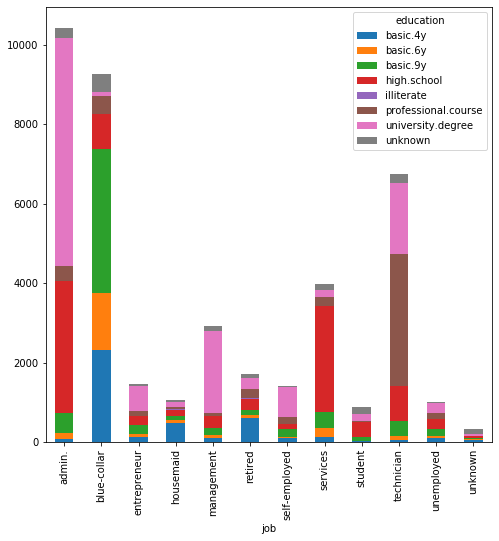

In [28]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

C1: Explore other categorical variables relationships</font>

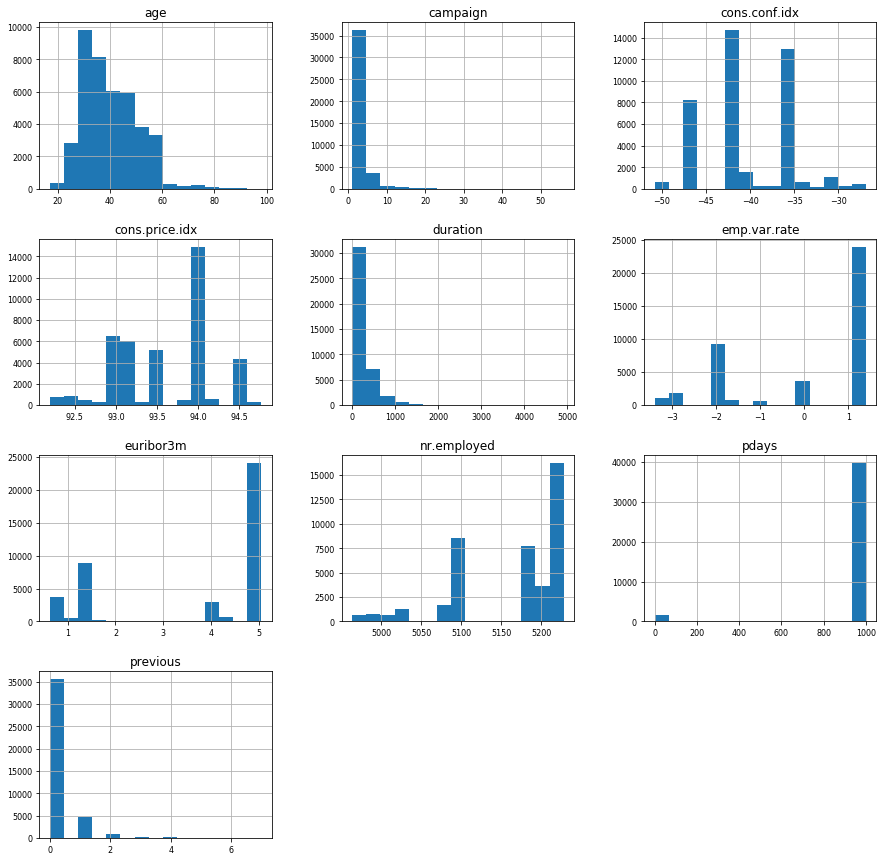

In [29]:
# Do histograms on all numeric variables
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()
ds[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, ylabelsize=8);

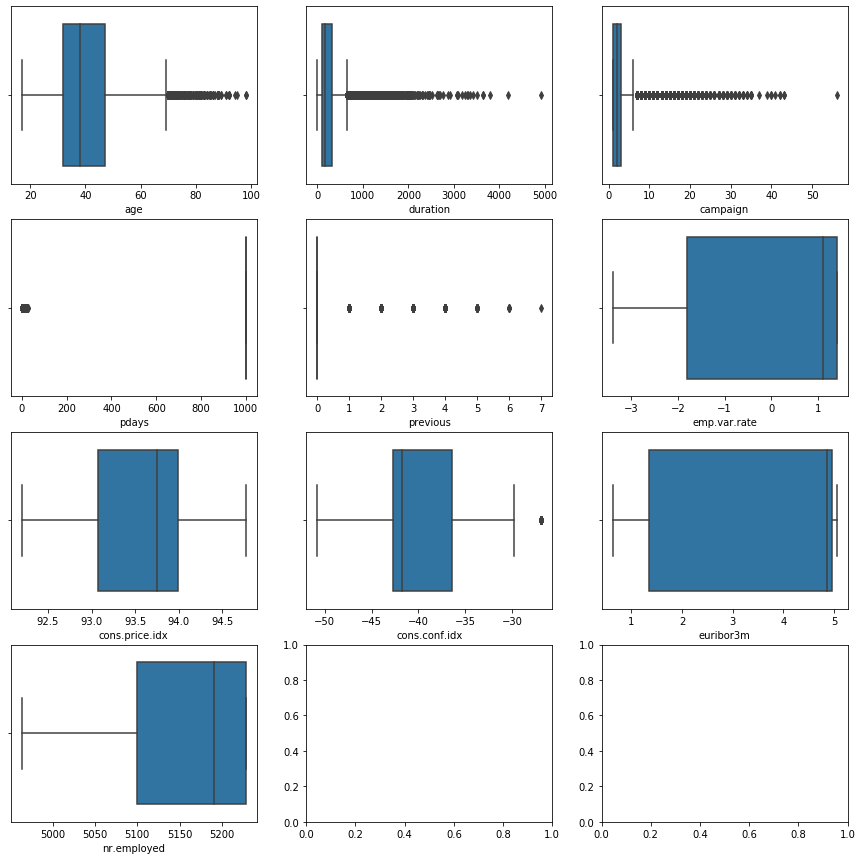

In [30]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(ds[var], ax=subplot)
    

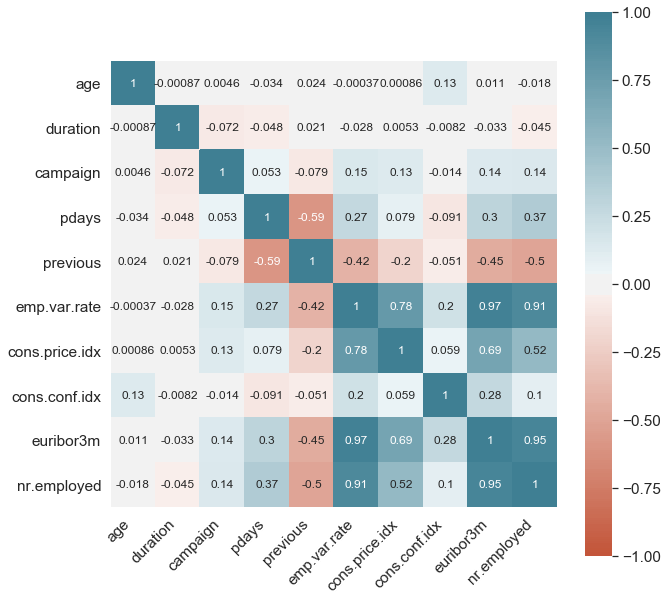

In [31]:
# Plot correlation heatmap of all numeric variables
corr = ds[numerical].corr()
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.4)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, annot_kws={"size": 12}
)
bottom, top = ax.get_ylim() # These two lines were added due to bug on current Seaborn version
ax.set_ylim(bottom + 0.5, top - 0.5) #
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

<font color='blue'>Q3: Are there any relevant correlations that indicate that the variables shoud be removed?</font>

### Data preparation

In [32]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [33]:
# Bin the age
X['age_bins'] = pd.cut(x=X['age'], bins=[0, 19, 29, 39, 49, 59, 99], labels=['<20','20-29','30-39','40-49','50-59','>=60'])

# Drop the age column
X.drop(columns='age', inplace=True)

In [34]:
# Remove columns that should not be used as they do not represent customer's characteristics or behavior
cols = ['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
X.drop(columns=cols, inplace=True)

In [35]:
# Encode target to 0 (no) and 1 (yes)
X['y'] = X['y'].map({'yes': 1, 'no': 0})

In [36]:
# Encode categorical variables to dummy variables
cols = ['default', 'housing', 'loan', 'poutcome', 'age_bins']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [37]:
# Encode multi-categorical variables to dummy variables (to avoid high cardinality and strange distributions)

# Function to return categories of columns based on threshold of distribution of the category
def one_hot(s, threshold,prefix):
    d = pd.get_dummies(s)
    f = pd.value_counts(s, sort=False, normalize=True) < threshold
    if f.sum() == 0:
        newSeries=d
    else:
        newSeries=d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('Other'))
    newSeries=newSeries.add_prefix(prefix)
    return newSeries

# One hot encoding of all categories above 15% - all others categories to "Other"
cols = ['job', 'marital', 'education']
for i in range(len(cols)):
    colToProcess = X[cols[i]].astype(str)
    procDF = one_hot(colToProcess, .15,cols[i]+'_')
    X.drop(columns=cols[i], inplace=True)
    X = pd.concat([X, procDF], axis=1)

In [38]:
# Normalize all columns
cols = list(X.columns) # save the name of the columns
X_array = X.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_array)
X = pd.DataFrame(X_scaled, columns=cols)

### Modeling

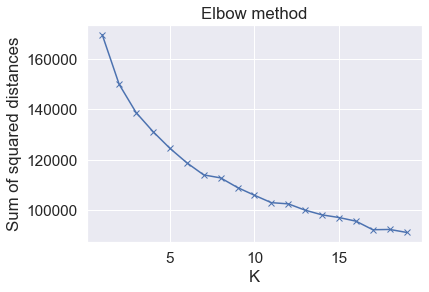

In [39]:
# Select K based on the sum of squared distances
ssd = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k, random_state=123)
    km = km.fit(X)
    ssd.append(km.inertia_)
    
# Plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method')
plt.show()

K should be 6 or 7

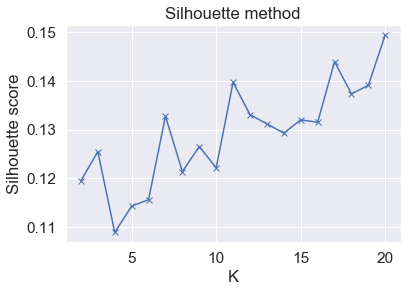

In [40]:
# Let's see if the Silhouette method gives the same result
sil = []
kmax = 20

# Dissimilarity can only be measured in more than 1 partition, therefore it starts on K=2
for k in range(2, kmax+1):
  km = KMeans(n_clusters = k, random_state=123).fit(X)
  labels = km.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))


# Plot results
plt.plot(range(2, kmax+1), sil, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette method')
plt.show()

With the Silhouette method, the number of clusters should be higher (K=20?)

**Other Approach**:<br>
Since there are multiple variables, let's try to reduce dimensionality using PCA